In [1]:
%matplotlib inline

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tf_image_segmentation.utils.training import get_valid_logits_and_labels

In [2]:
filenames = ["/home/thalles_silva/DataPublic/SemanticSegmentation/Datasets/PascalVoc2012/train/VOC2012/ImageSets/Segmentation/train.txt"]
training_images_dir = "/home/thalles_silva/DataPublic/SemanticSegmentation/Datasets/PascalVoc2012/train/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles_silva/DataPublic/SemanticSegmentation/Datasets/PascalVoc2012/train/VOC2012/SegmentationClass_1D/"

In [3]:
class_labels = [value for value in range(21)]
image_train_size = [384, 384]

In [4]:
def scale_randomly_image_with_annotation_with_fixed_size_output(img_tensor,
                                                                annotation_tensor,
                                                                output_shape,
                                                                min_relative_random_scale_change=0.9,
                                                                max_realtive_random_scale_change=1.1,
                                                                mask_out_number=255):
    """Returns tensor of a size (output_shape, output_shape, depth) and (output_shape, output_shape, 1).
    The function returns tensor that is of a size (output_shape, output_shape, depth)
    which is randomly scaled by a factor that is sampled from a uniform distribution
    between values [min_relative_random_scale_change, max_realtive_random_scale_change] multiplied
    by the factor that is needed to scale image to the output_shape. When the rescaled image
    doesn't fit into the [output_shape] size, the image is either padded or cropped. Also, the
    function returns scaled annotation tensor of the size (output_shape, output_shape, 1). Both,
    the image tensor and the annotation tensor are scaled using nearest neighbour interpolation.
    This was done to preserve the annotation labels. Be careful when specifying the big sample
    space for the random variable -- aliasing effects can appear. When scaling, this function
    preserves the aspect ratio of the original image. When performing all of those manipulations
    there will be some regions in the output image with blank regions -- the function masks out
    those regions in the annotation using mask_out_number. Overall, the function performs the
    rescaling neccessary to get image of output_shape, adds random scale jitter, preserves
    scale ratio, masks out unneccassary regions that appear.
    
    Parameters
    ----------
    img_tensor : Tensor of size (width, height, depth)
        Tensor with image
    annotation_tensor : Tensor of size (width, height, 1)
        Tensor with respective annotation
    output_shape : Tensor or list [int, int]
        Tensor of list representing desired output shape
    min_relative_random_scale_change : float
        Lower bound for uniform distribution to sample from
        when getting random scaling jitter
    max_realtive_random_scale_change : float
        Upper bound for uniform distribution to sample from
        when getting random scaling jitter
    mask_out_number : int
        Number representing the mask out value.
        
    Returns
    -------
    cropped_padded_img : Tensor of size (output_shape[0], output_shape[1], 3).
        Image Tensor that was randomly scaled
    cropped_padded_annotation : Tensor of size (output_shape[0], output_shape[1], 1)
        Respective annotation Tensor that was randomly scaled with the same parameters
    """
    
    # tf.image.resize_nearest_neighbor needs
    # first dimension to represent the batch number
    img_batched = tf.expand_dims(img_tensor, 0)
    annotation_batched = tf.expand_dims(annotation_tensor, 0)

    # Convert to int_32 to be able to differentiate
    # between zeros that was used for padding and
    # zeros that represent a particular semantic class
    annotation_batched = tf.to_int32(annotation_batched)

    # Get height and width tensors
    input_shape = tf.shape(img_batched)[1:3]

    input_shape_float = tf.to_float(input_shape)

    scales = output_shape / input_shape_float

    rand_var = tf.random_uniform(shape=[1],
                                 minval=min_relative_random_scale_change,
                                 maxval=max_realtive_random_scale_change)

    final_scale = tf.reduce_min(scales) * rand_var

    scaled_input_shape = tf.to_int32(tf.round(input_shape_float * final_scale))
    
    # Resize the image and annotation using nearest neighbour
    # Be careful -- may cause aliasing.
    
    # TODO: try bilinear resampling for image only
    resized_img = tf.image.resize_images(img_batched, scaled_input_shape )
    resized_annotation = tf.image.resize_nearest_neighbor( annotation_batched, scaled_input_shape )

    resized_img = tf.squeeze(resized_img, axis=0)
    resized_annotation = tf.squeeze(resized_annotation, axis=0)

    # Shift all the classes by one -- to be able to differentiate
    # between zeros representing padded values and zeros representing
    # a particular semantic class.
    annotation_shifted_classes = resized_annotation + 1

    cropped_padded_img = tf.image.resize_image_with_crop_or_pad( resized_img, output_shape[0], output_shape[1] )

    cropped_padded_annotation = tf.image.resize_image_with_crop_or_pad(annotation_shifted_classes,
                                                                       output_shape[0],
                                                                       output_shape[1])
    
    # TODO: accept the classes lut instead of mask out
    # value as an argument
    annotation_additional_mask_out = tf.to_int32(tf.equal(cropped_padded_annotation, 0)) * (mask_out_number+1)

    cropped_padded_annotation = cropped_padded_annotation + annotation_additional_mask_out - 1
    
    return cropped_padded_img, cropped_padded_annotation

In [5]:
def get_labels_from_annotation(annotation_tensor, class_labels):
    
    # Stack the binary masks for each class
    labels_2d = list(map(lambda x: tf.equal(annotation_tensor, x),
                    class_labels))

    # Perform the merging of all of the binary masks into one matrix
    labels_2d_stacked = tf.stack(labels_2d, axis=2)
    
    # Convert tf.bool to tf.float
    # Later on in the labels and logits will be used
    # in tf.softmax_cross_entropy_with_logits() function
    # where they have to be of the float type.
    labels_2d_stacked = tf.cast(labels_2d_stacked, tf.float32)
    
    return labels_2d_stacked

In [6]:
def process_labels(annotation_batch_tensor, class_labels):
    # annotation_batch_tensor shape: (batch_size, width, height)
    # return (batch_size, width, height, num_classes)
    batch_labels = tf.map_fn(fn=lambda x: get_labels_from_annotation(annotation_tensor=x, class_labels=class_labels),
                         elems=annotation_batch_tensor,
                         dtype=tf.uint8)
    
    return batch_labels

In [10]:
def read_and_decode_single_image_and_label(filename_queue, resize=True, image_size=[384, 384]):
    reader = tf.TextLineReader()
    key, img_filename = reader.read(filename_queue)

    # read the input and annotation images
    image_tensor = tf.read_file(training_images_dir + img_filename + ".jpg")
    annotation_tensor = tf.read_file(training_labels_dir + img_filename + ".png")

    image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
    annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
    
    if resize:     
        resized_image, resized_annotation = scale_randomly_image_with_annotation_with_fixed_size_output(image_tensor, annotation_tensor, image_size)
    
    return resized_image, resized_annotation

In [11]:
def next_batch(filenames, batch_size=5, num_epochs=None, shuffle=True, image_size=[384, 384]):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=num_epochs, shuffle=shuffle)
    
    # get single examples
    image, label = read_and_decode_single_image_and_label(filename_queue, image_size=image_size)
    
    # groups examples into batches randomly
    images_batch, labels_batch = tf.train.shuffle_batch(
        [image, label], batch_size=batch_size,
        capacity=80,
        min_after_dequeue=40)
    
    return images_batch, labels_batch

In [26]:
images_batch, labels_batch = next_batch(filenames)

# reduces labels_batch shape from (BATCH_SIZE,HEIGHT,WIDTH,1) to (BATCH_SIZE,HEIGHT,WIDTH)
annotation_tensor = tf.squeeze(labels_batch, axis=3)

#annotation_masks = process_labels(annotation_tensor, class_labels)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

images, labels = sess.run([images_batch, labels_batch])

print(ann_masks.shape)

(5, 384, 384, 21)


In [27]:
print(images[0].dtype)

float32


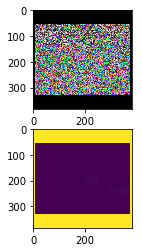

In [17]:
f, axarr = plt.subplots(2)
axarr[0].imshow(images[0])
axarr[1].imshow(np.squeeze(labels[0]))

In [25]:
print(labels[0, 100:120, 100:120,:])

[[[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]


In [34]:
# read the input and annotation images
image_tensor = tf.read_file(training_images_dir + "2007_000170.jpg")
annotation_tensor = tf.read_file(training_labels_dir + "2007_000170.png")

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

annotation_tensor = tf.expand_dims(annotation_tensor, axis=0)
annotation_tensor = tf.squeeze(annotation_tensor, axis=3)

out = process_labels(annotation_tensor, class_labels)

In [35]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
images, annotation_mask = sess.run([annotation_tensor, out])

In [37]:
print(annotation_mask.shape)

(1, 375, 500, 21)
